In [1]:
import io
import os
import numpy as np
import pandas as pd
import gzip as gz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib_venn import venn2, venn3

sns.set_theme(font="Arial", font_scale=1.15, style='ticks') 
matplotlib.rcParams['figure.dpi'] = 300
plt.rc("axes.spines", top=True, right=True)

def read_vcf(path):
    if path[-3:] == ".gz": 
        with gz.open(path, 'rb') as f:
            lines = [l.decode('utf-8') for l in f if not l.startswith(b'##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})
    else:
        with open(path, 'r') as f:
            lines = [l for l in f if not l.startswith('##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})

def vcf_format_getter(df, field) -> pd.Series:
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        GT, VAF, DP, AD
    
    return pd.Series

    Example vcf structure
    ----------
    FORMAT              COLO829T_PassageB_DSA  
    GT:GQ:DP:AD:VAF:PL  1/1:59:133:2,131:0.984962:65,60,0
    GT:GQ:DP:AD:VAF:PL  1/1:65:131:0,131:1:70,66,0
    GT:GQ:DP:AD:VAF:PL  1/1:53:49:0,49:1:58,54,0

    """
    sampleid = df.columns[9]
    format = list(set(df['FORMAT'].values))[0].split(':')

    if field == "GT":
        gtindex = format.index('GT')
        return df[sampleid].str.split(':').apply(lambda x: x[gtindex])
    
    elif field == "VAF":
        vafindex = format.index('VAF')
        return df[sampleid].str.split(':').apply(lambda x: float(x[vafindex]))
    
    elif field == "DP":
        dpindex = format.index('DP')
        return df[sampleid].str.split(':').apply(lambda x: int(x[dpindex]))
    
    elif field == "AD":
        adindex = format.index('AD')
        return df[sampleid].str.split(':').apply(lambda x: int(x[adindex].split(',')[1]))
    
    else:
        raise ValueError("field should be one of GT, VAF, DP and AD!")

def vcf_info_parser(info_string) -> dict:
    """
    Parameters
    ----------
    info_string : str
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1

    return dict

    """
    return {i.split('=')[0]: i.split('=')[1] for i in info_string.split(';')}

def vcf_info_getter(df, field):
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        VAF_Ill, VAF_PB
    
    return pd.Series

    Example vcf structure
    ----------
    INFO
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1
    SP=STK,RF,MT2,VN;RGN=Easy;RGN_T=Tier0;VAF_Ill=0.981;VAF_PB=0.984
    """

    if field == "RGN":
        return df['INFO'].apply(lambda x: vcf_info_parser(x)[field])
    
    elif field == "RGN_T":
        return df['INFO'].apply(lambda x: vcf_info_parser(x)[field])
    
    elif field == "VAF_Ill" or field == "VAF_PB":
        return df['INFO'].apply(lambda x: float(vcf_info_parser(x)[field]) if vcf_info_parser(x)[field] != 'NA' else np.nan)

    else:
        raise ValueError("field should be one of RGN, RGN_T, VAF_Ill and VAF_PB!")

def make_site_list(df: pd.DataFrame, path: str, prefix: str) -> None:
    """
    Parameters
    ----------
    df : pandas.core.frame.DataFrame 
        vcf read through read_vcf()
    path : str

    prefix : str

    return target_list 
    """
    
    df = df[['CHROM', 'POS', 'POS']].drop_duplicates()
    
    df.to_csv(f"{os.path.join(path, prefix)}.sitelist", sep='\t', index=False, header=False)

dir="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq"
#dir="/Users/mhryansohn/Desktop/01.Workspace/02.Institution/04.UW/Variant_Truset"

DSA="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/DSA/DSA_COLO829BL_v3.0.0.fasta"

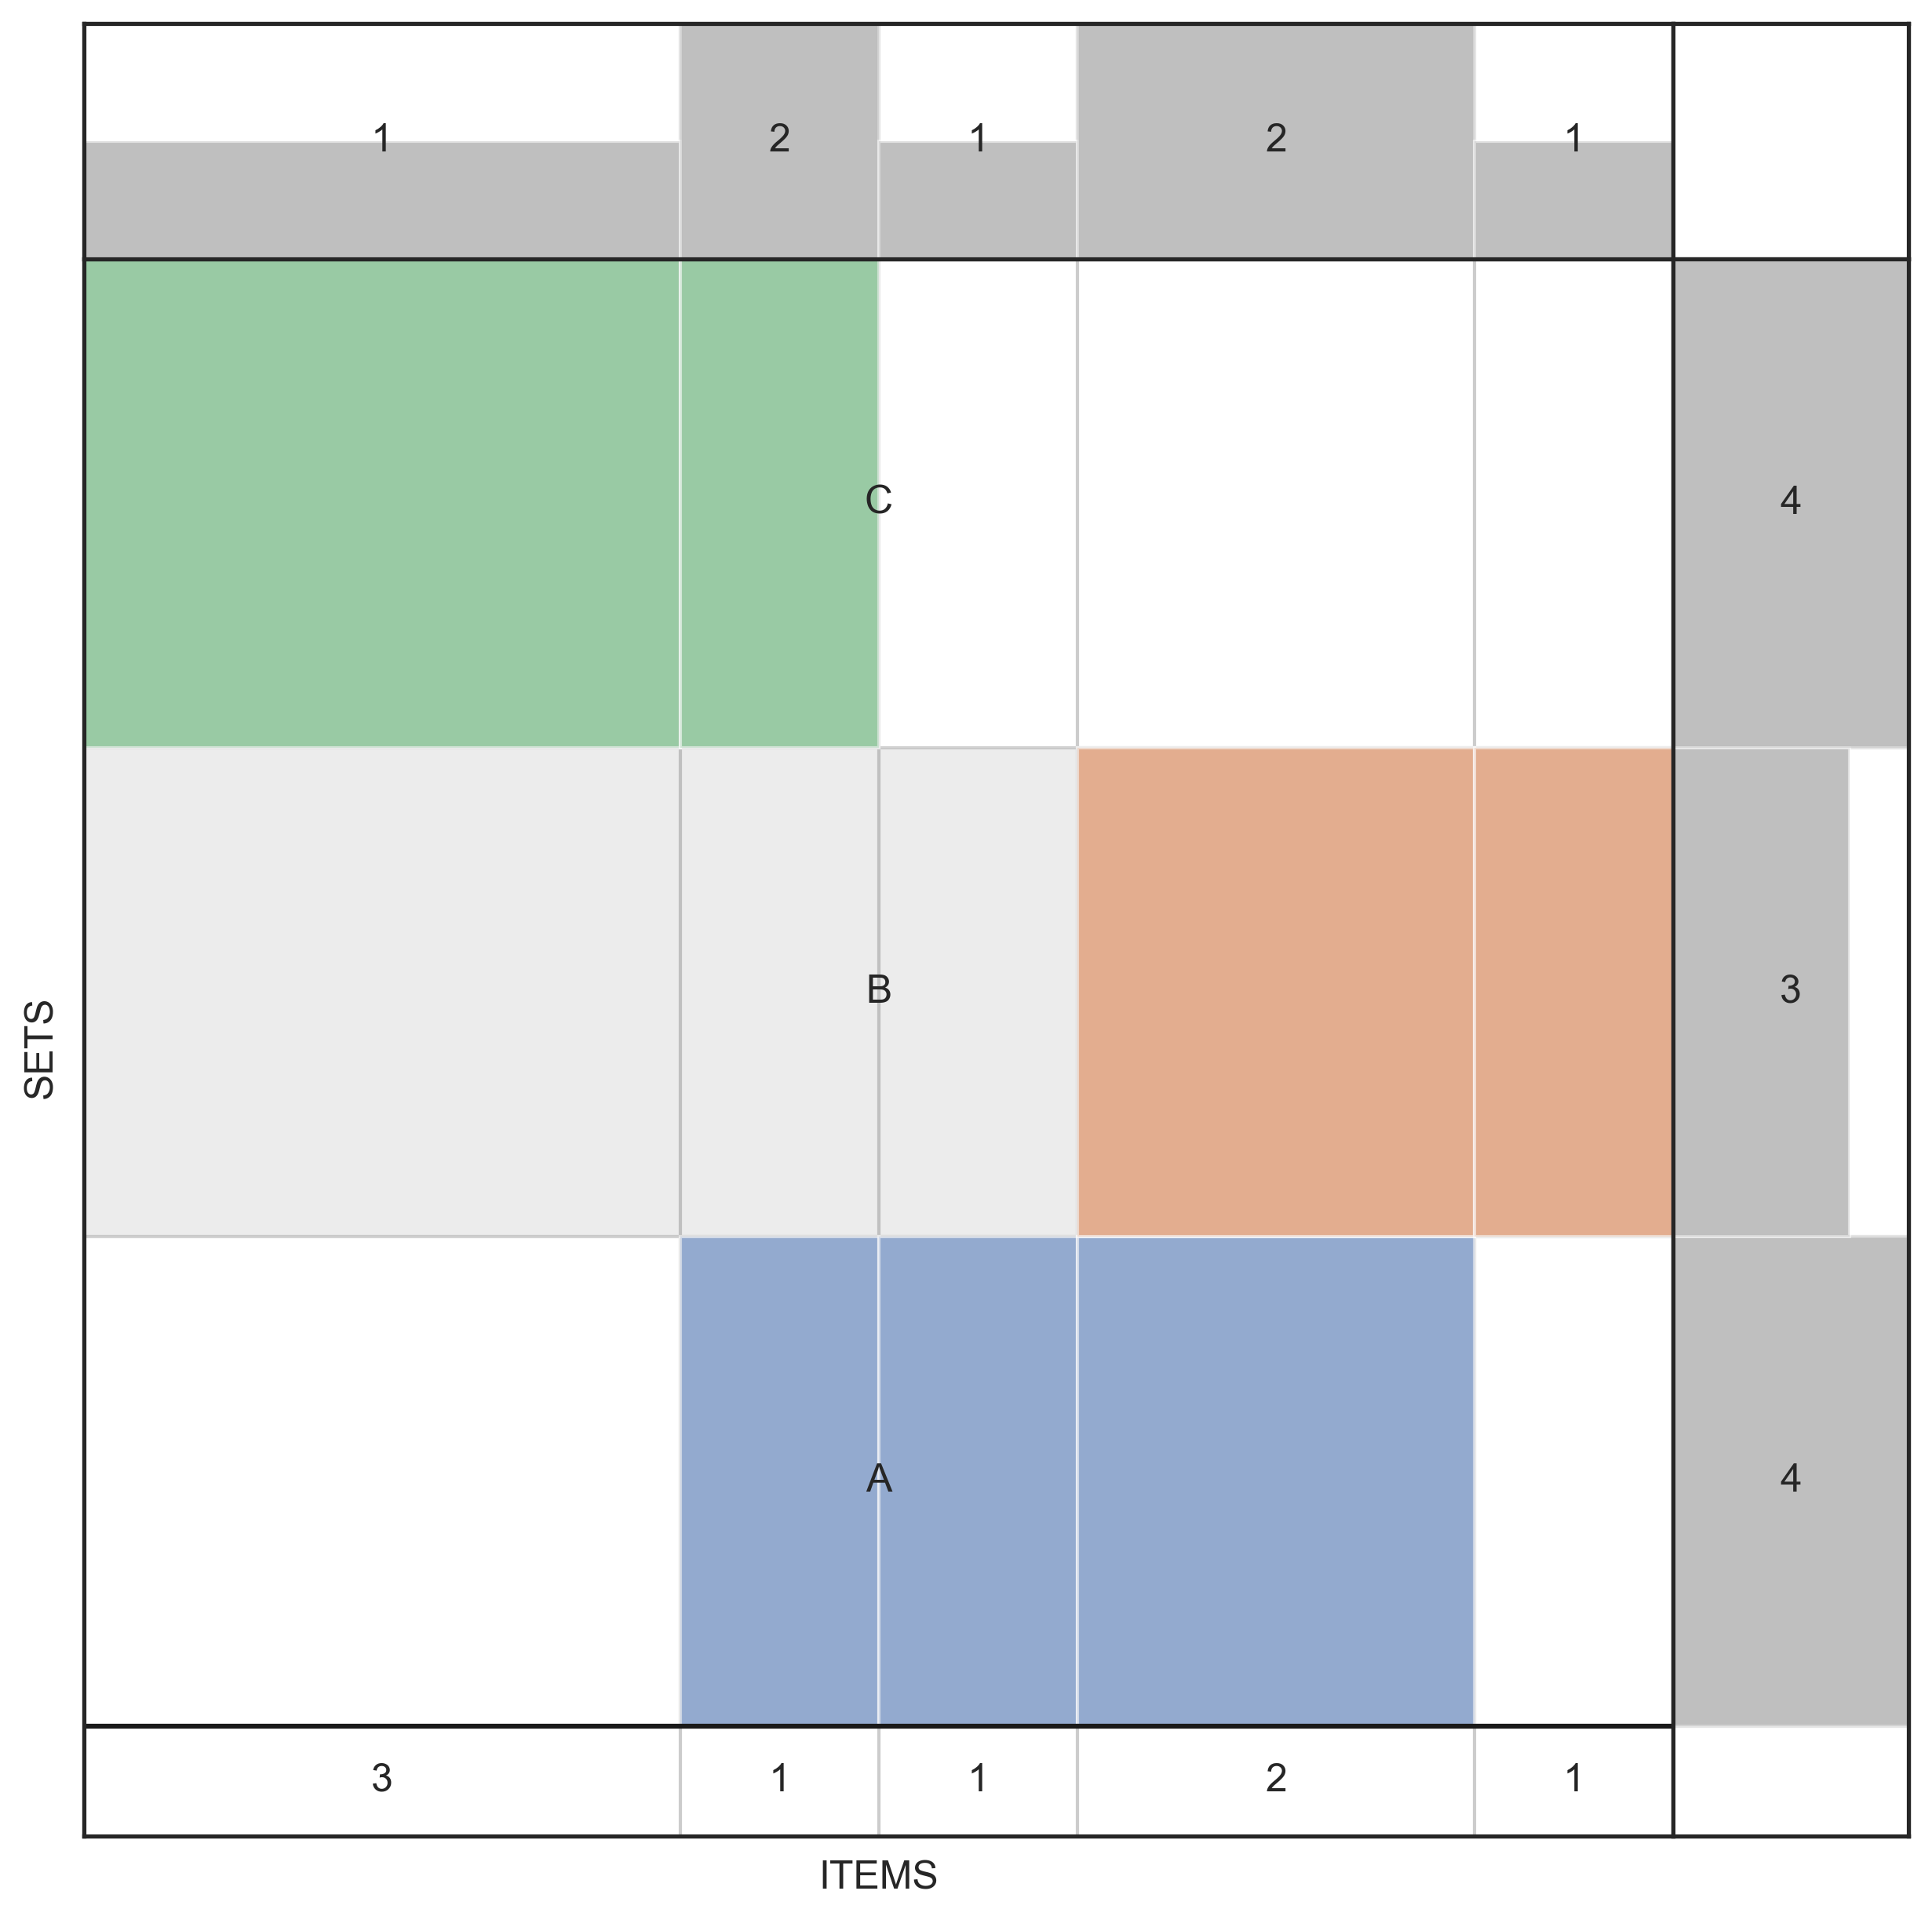

In [6]:
from supervenn import supervenn
fig, ax = plt.subplots(1,1, figsize=(10,10), constrained_layout=False)
sets: list[set] = [{1, 2, 3, 4}, {3, 4, 5}, {1, 6, 7, 8}]
labels: list[str] = ['A', 'B', 'C']
supervenn(sets, labels, side_plots=True, ax=ax)

In [3]:
colobl_vcf = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829BL/deepvariant/COLO829BL.deepvariant.split.indel.vcf.gz")
colotb_vcf = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.split.indel.vcf.gz")
colota_vcf = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.split.indel.vcf.gz")

In [4]:
colobl_indels_pass = colobl_vcf[(colobl_vcf['FILTER'] == 'PASS')].reset_index(drop=True)
colotb_indels_pass = colotb_vcf[(colotb_vcf['FILTER'] == 'PASS')].reset_index(drop=True)
colota_indels_pass = colota_vcf[(colota_vcf['FILTER'] == 'PASS')].reset_index(drop=True)

colobl_indels_pass['INDELid'] = colobl_indels_pass[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colotb_indels_pass['INDELid'] = colotb_indels_pass[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)
colota_indels_pass['INDELid'] = colota_indels_pass[['CHROM', 'POS', 'REF', 'ALT']].astype(str).apply('_'.join, axis=1)

In [5]:
colobl_flagger = pd.read_table(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829BL/deepvariant/COLO829BL.deepvariant.split.indel.flagger", sep='\t', header=None)
colobl_flagger.columns = ['INDELid', 'FILTER', 'Flagger']
colotb_flagger = pd.read_table(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.split.indel.flagger", sep='\t', header=None)
colotb_flagger.columns = ['INDELid', 'FILTER', 'Flagger']
colota_flagger = pd.read_table(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.split.indel.flagger", sep='\t', header=None)
colota_flagger.columns = ['INDELid', 'FILTER', 'Flagger']

colobl_indels_pass_annot = pd.merge(colobl_indels_pass, colobl_flagger[['INDELid', 'Flagger']], on='INDELid', how='left')
colotb_indels_pass_annot = pd.merge(colotb_indels_pass, colotb_flagger[['INDELid', 'Flagger']], on='INDELid', how='left')
colota_indels_pass_annot = pd.merge(colota_indels_pass, colota_flagger[['INDELid', 'Flagger']], on='INDELid', how='left')

print(colobl_indels_pass_annot['Flagger'].value_counts())
print(colotb_indels_pass_annot['Flagger'].value_counts())
print(colota_indels_pass_annot['Flagger'].value_counts())

Flagger
Hap    64514
Err     7610
Dup     2921
Col      617
Unk      121
Name: count, dtype: int64
Flagger
Hap    67862
Err     5527
Dup     2931
Col      602
Unk      120
Name: count, dtype: int64
Flagger
Hap    71356
Err     5439
Dup     3499
Col      646
Unk      102
Name: count, dtype: int64


In [6]:
colobl_indels_pass_set = set(colobl_indels_pass['INDELid'].values)
colotb_indels_pass_set = set(colotb_indels_pass['INDELid'].values)
colota_indels_pass_set = set(colota_indels_pass['INDELid'].values)

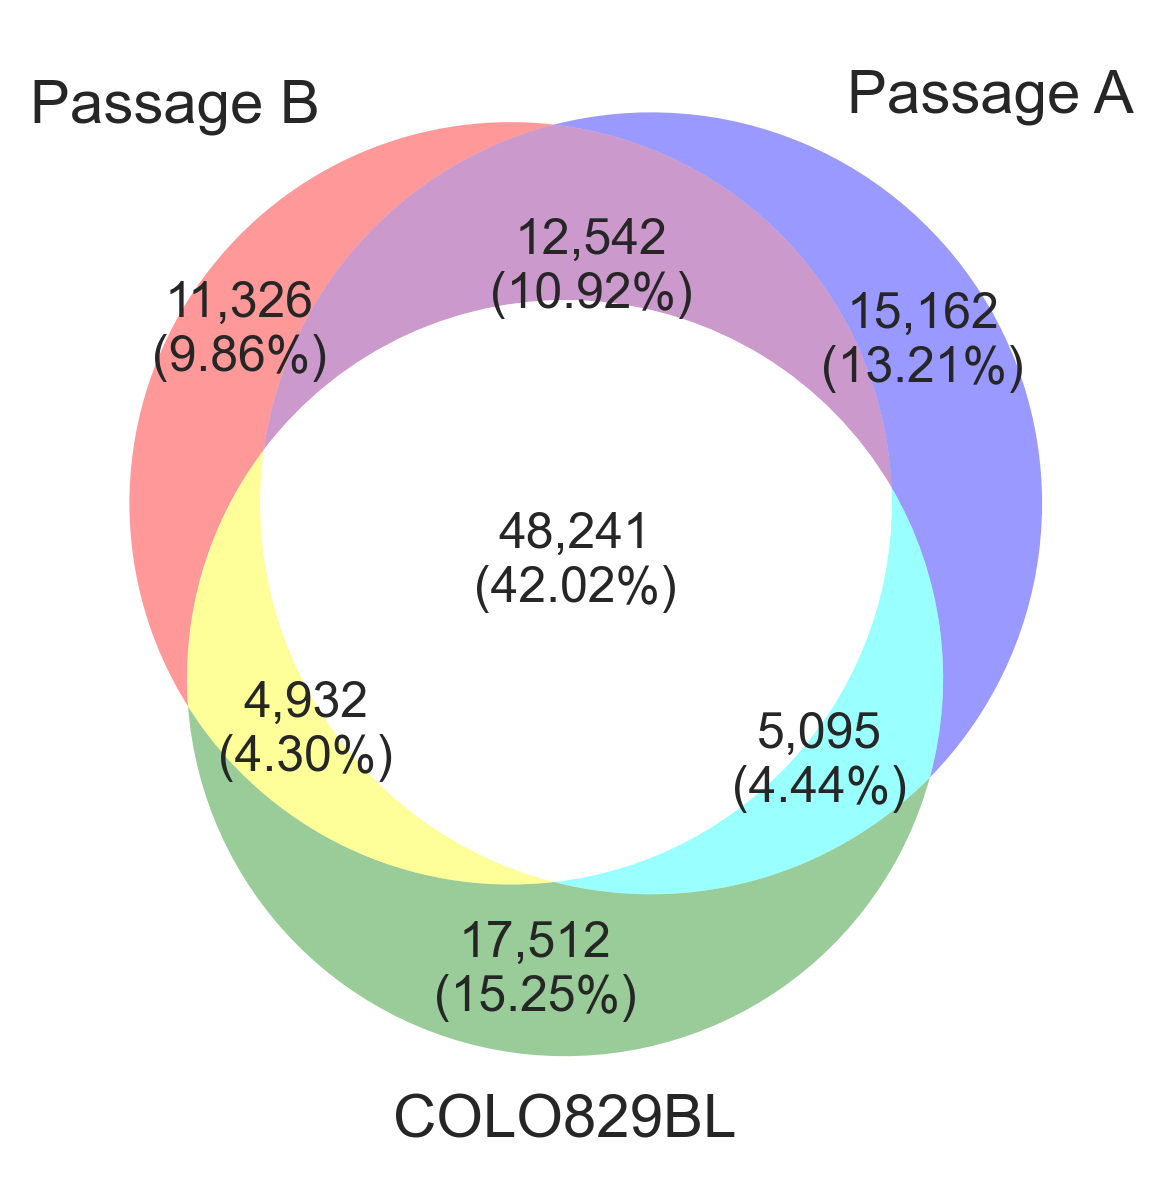

In [7]:
sns.set_theme(font="Arial", font_scale=1.00, style='ticks')
matplotlib.rcParams['figure.dpi'] = 300
plt.rc("axes.spines", top=False, right=False)

total = len((colotb_indels_pass_set.union(colota_indels_pass_set)).union(colobl_indels_pass_set))
venn = venn3([colotb_indels_pass_set, colota_indels_pass_set, colobl_indels_pass_set], 
             ('Passage B', 'Passage A', 'COLO829BL'),
             subset_label_formatter=lambda x: f"{x:,}\n({(x/total):.2%})")
venn.get_patch_by_id('100').set_color('red')
venn.get_patch_by_id('010').set_color('blue')
venn.get_patch_by_id('001').set_color('green')
venn.get_patch_by_id('110').set_color('purple')
venn.get_patch_by_id('101').set_color('yellow')
venn.get_patch_by_id('011').set_color('cyan')
venn.get_patch_by_id('111').set_color('white')


for i in ['100', '010', '001', '110', '101', '011', '111']:
    venn.get_patch_by_id(i).set_edgecolor('none')
    venn.get_patch_by_id(i).set_alpha(0.4)

In [8]:
tb_glfilt_onlytb_set = colotb_indels_pass_set.difference(colota_indels_pass_set).difference(colobl_indels_pass_set)
ta_glfilt_onlyta_set = colota_indels_pass_set.difference(colotb_indels_pass_set).difference(colobl_indels_pass_set)
tba_glfilt_tba_set = colotb_indels_pass_set.difference(colobl_indels_pass_set).intersection(colota_indels_pass_set.difference(colobl_indels_pass_set))

colot_glfilt_set = tb_glfilt_onlytb_set.union(ta_glfilt_onlyta_set).union(tba_glfilt_tba_set)
print(f'{len(tb_glfilt_onlytb_set):,}')
print(f'{len(ta_glfilt_onlyta_set):,}')
print(f'{len(tba_glfilt_tba_set):,}')
print(f'{len(colot_glfilt_set):,}')

#print("These two should be the same")
#print(colotb_indels_pass_annot[colotb_indels_pass_annot['INDELid'].isin(tba_glfilt_tba_set)]['Flagger'].value_counts())
#print(colota_indels_pass_annot[colota_indels_pass_annot['INDELid'].isin(tba_glfilt_tba_set)]['Flagger'].value_counts())

11,326
15,162
12,542
39,030


In [9]:
colotb_indels_pass_annot_FlaggerHap_glfilt = colotb_indels_pass_annot[
    (colotb_indels_pass_annot['INDELid'].isin(colot_glfilt_set)) & 
    (colotb_indels_pass_annot['Flagger'] == 'Hap')
    ].reset_index(drop=True)

colota_indels_pass_annot_FlaggerHap_glfilt = colota_indels_pass_annot[
    (colota_indels_pass_annot['INDELid'].isin(colot_glfilt_set)) & 
    (colota_indels_pass_annot['Flagger'] == 'Hap')
    ].reset_index(drop=True)

In [10]:
"""
make_site_list(colotb_indels_pass_annot_FlaggerHap_glfilt, 
               f'{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant', "COLO829T_PassageB_DSA.deepvariant.split.indel.flaggerhap.glfilt")
make_site_list(colota_indels_pass_annot_FlaggerHap_glfilt, 
               f'{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant', "COLO829T_PassageA_DSA.deepvariant.split.indel.flaggerhap.glfilt")

os.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.split.indel.flaggerhap.glfilt.sitelist {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.split.indel.flaggerhap.glfilt.sitelist | sort -k1,1 -k2,2n - | uniq > {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageCombined_DSA.indel.sitelist")
"""

'\nmake_site_list(colotb_indels_pass_annot_FlaggerHap_glfilt, \n               f\'{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant\', "COLO829T_PassageB_DSA.deepvariant.split.indel.flaggerhap.glfilt")\nmake_site_list(colota_indels_pass_annot_FlaggerHap_glfilt, \n               f\'{dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant\', "COLO829T_PassageA_DSA.deepvariant.split.indel.flaggerhap.glfilt")\n\nos.system(f"cat {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageB_DSA/deepvariant/COLO829T_PassageB_DSA.deepvariant.split.indel.flaggerhap.glfilt.sitelist {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageA_DSA/deepvariant/COLO829T_PassageA_DSA.deepvariant.split.indel.flaggerhap.glfilt.sitelist | sort -k1,1 -k2,2n - | uniq > {dir}/VariantCalls_DeepVariant_1.6.1/COLO829T_PassageCombined_DSA.indel.sitelist")\n'

In [26]:
#haplotype1-0000001:80042246
#haplotype1-0000001:625628

colota_indels_pass_annot_FlaggerHap_glfilt[colota_indels_pass_annot_FlaggerHap_glfilt['POS'] == 80042246]

colota_indels_pass_annot_FlaggerHap_glfilt[colota_indels_pass_annot_FlaggerHap_glfilt['POS'] == 625628]

colotb_indels_pass_annot_FlaggerHap_glfilt[colotb_indels_pass_annot_FlaggerHap_glfilt['POS'] == 625628]

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,COLO829T_PassageB_DSA,INDELid,Flagger
0,haplotype1-0000001,625628,.,A,AT,51.8,PASS,.,GT:GQ:DP:AD:VAF:PL,"1/1:36:91:37,34:0.373626:51,35,0",haplotype1-0000001_625628_A_AT,Hap


In [31]:
colobl_pileup = read_vcf(f"{dir}/VariantCalls_DeepVariant_1.6.1/COLO829BL/deepvariant/COLO829BL.colotindelpileup.vcf.gz")

colobl_pileup = colobl_pileup[colobl_pileup['INFO'].str.startswith('INDEL')]

colobl_pileup


,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/COLO829BL/COLO829BL_DSA_resetmapq.cram
1,haplotype1-0000001,625628,.,ATTTTTTTTTTTTTTTTTTTTTTTT,"ATTTTTTTTTTTTTTTTTTTTTTTTT,ATTTTTTTTTTTTTTTTTT...",0,.,"INDEL;IDV=97;IMF=0.530055;DP=183;I16=39,47,46,...",PL:AD,"130,54,87,168,70,168,138,0,53,58:86,45,30,11"
3,haplotype1-0000001,924188,.,GCCCCCCCCCCCCC,"GCCCCCCCCCCCCCC,GCCCCCCCCCCCC,GCCCCCCCCCCCCCCC",0,.,"INDEL;IDV=64;IMF=0.397516;DP=161;I16=55,42,28,...",PL:AD,"83,43,66,178,44,148,175,0,56,78:97,33,19,8"
5,haplotype1-0000001,1708714,.,CTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT,"CTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT,CTTTTT...",0,.,"INDEL;IDV=101;IMF=0.664474;DP=152;I16=27,24,51...",PL:AD,"33,0,39,42,44,62,43,43,25,28:51,48,25,12"
7,haplotype1-0000001,2005052,.,CAAAAAAAAAAAAAAAAAAAAAAAAAAAA,"CAAAAAAAAAAAAAAAAAAAAAAAAAAAAA,CAAAAAAAAAAAAAA...",0,.,"INDEL;IDV=33;IMF=0.181319;DP=182;I16=57,92,13,...",PL:AD,"0,233,48,255,40,53,255,68,53,81:149,17,4,4"
9,haplotype1-0000001,2042234,.,AAATAATAATAATAATAATAATAATAATAATAATAATAATA,AAATAATAATAATAATAATAATAATAATAATAATAATAATAATAAT...,0,.,"INDEL;IDV=27;IMF=0.137755;DP=196;I16=53,116,13...",PL:AD,"66,106,17,255,0,230,255,25,202,244:169,20,4,2"
...,...,...,...,...,...,...,...,...,...,...
58636,haplotype2-0000189,8354,.,GAATGGAATGGAATGGAATGGAATGGAATGCAATGGAATGGAATGG...,"GAATGGAATGGAATGGAATG,GAATGGAACGCAACGGAATGGAATG...",0,.,"INDEL;IDV=29;IMF=0.131818;DP=220;I16=118,73,15...",PL:AD,"0,12,143,255,199,255:191,28,1"
58638,haplotype2-0000189,8616,.,AGGAATAGAATGGAAT,"AGGAAT,AGTAATGGAATGGAATAGAATGGAAT,ACGGAATAGAAT...",0,.,"INDEL;IDV=49;IMF=0.217778;DP=225;I16=99,77,36,...",PL:AD,"255,228,138,255,0,255,255,228,255,255:176,34,14,1"
58640,haplotype2-0000189,8736,.,CGTAATGGAATGGAATGGAATGGAATGGAATG,"CGGAATGGAATGGAATG,CGGAATGGAATGGAATGGAATGGAATG,...",0,.,"INDEL;IDV=38;IMF=0.161702;DP=235;I16=123,77,20...",PL:AD,"0,92,99,255,11,255,255,154,255,255:200,23,9,1"
58642,haplotype2-0000189,8881,.,CAGAATGGAATGGAATGGAATGGAATGGAAT,"CGGAATGGAATAGAATGGAATGGAATGGAATGGAATGGAAT,CGGA...",0,.,"INDEL;IDV=92;IMF=0.383333;DP=240;I16=94,54,51,...",PL:AD,"210,18,255,114,0,255,255,255,255,255:148,45,31,1"


In [19]:
print(dir)

/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq
